# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/碩一下/自動駕駛/project1')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (985, 1915, 3)


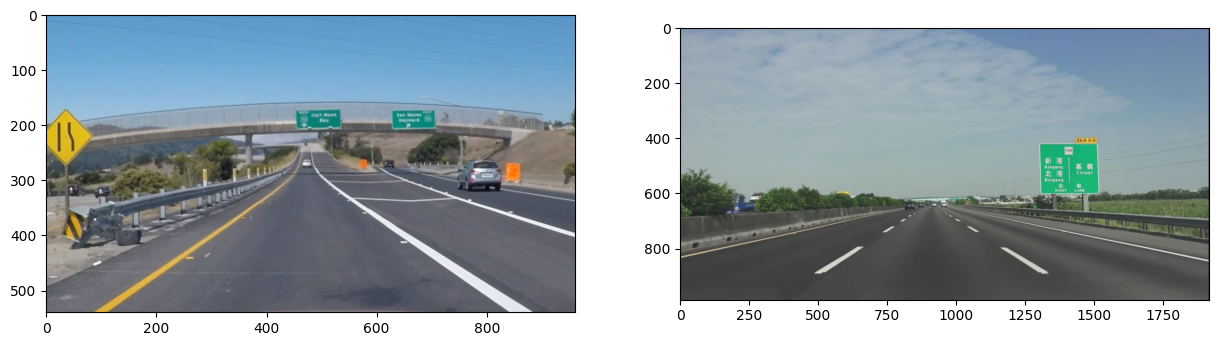

In [ ]:
#reading in an image
image1 = mpimg.imread('canny.jpg')
image2 = mpimg.imread('test.jpg')

#printing out some stats and plotting
fig = plt.figure(figsize=(15,30))
print('This image is:', type(image1), 'with dimensions:', image1.shape)
plt.subplot(121)
plt.imshow(image1)
print('This image is:', type(image2), 'with dimensions:', image2.shape)
plt.subplot(122)
plt.imshow(image2)

plt.show()

# Define Functions

In [ ]:
i=0
k=0
save_io = True


def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if save_io == True:
        cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_Gary/Gary_'+str(i)+'.jpg',img)
    else:
        pass
    return img


def canny(img, low_threshold, high_threshold):
    global i
    c = cv2.Canny(img, low_threshold, high_threshold)
    if save_io == True:
        cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_canny/canny_'+str(i)+'.jpg',c)
    else:
        pass
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def region_of_interest01(img, vertices):
    mask = np.zeros(img)
    cv2.fillPoly(mask, vertices, [255,0,0])
    return mask



def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    global i, k, save_io

    top = int(img.shape[0]*0.65)
    bottom = img.shape[0]
    slope_limit_min = 0.3      #the minimum limit of the slope
    slope_limit_max = 1        #the maximum limit of the slope
    left_x1_set = []
    left_y1_set = []
    left_x2_set = []
    left_y2_set = []
    right_x1_set = []
    right_y1_set = []
    right_x2_set = []
    right_y2_set = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if slope < 0:
                if slope > (-1*slope_limit_min) or slope < (-1*slope_limit_max):
                    continue
                left_x1_set.append(x1)
                left_y1_set.append(y1)
                left_x2_set.append(x2)
                left_y2_set.append(y2)
            else:
                if slope < slope_limit_min or slope > slope_limit_max:
                    continue
                right_x1_set.append(x1)
                right_y1_set.append(y1)
                right_x2_set.append(x2)
                right_y2_set.append(y2)

    try:
        avg_right_x1 = int(np.mean(right_x1_set))
        avg_right_y1 = int(np.mean(right_y1_set))
        avg_right_x2 = int(np.mean(right_x2_set))
        avg_right_y2 = int(np.mean(right_y2_set))
        right_slope = get_slope(avg_right_x1,avg_right_y1,avg_right_x2,avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x2 + (right_y2 - avg_right_y2) / right_slope)
        g = cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
        if save_io == True:
            cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_line_right/right_'+str(i)+'.jpg',g)
        else:
            pass

    except ValueError:
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1_set))
        avg_left_y1 = int(np.mean(left_y1_set))
        avg_left_x2 = int(np.mean(left_x2_set))
        avg_left_y2 = int(np.mean(left_y2_set))
        left_slope = get_slope(avg_left_x1,avg_left_y1,avg_left_x2,avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x2 + (left_y2 - avg_left_y2) / left_slope)
        y = cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
        if save_io == True:
            cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_line_left/left_'+str(i)+'.jpg',y)
        else:
            pass
        i = i + 1

    except ValueError:
        pass


def get_slope(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines_easy(line_img,lines)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)




# Define Functions Myself

In [ ]:
def color_change(image):
    blue_threshold = 5#32
    green_threshold = 120#220#90
    red_threshold = 255#250#130
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    thresholds = (image[:,:,0] > rgb_threshold[0]) \
                | (image[:,:,1] > rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    image[thresholds] = [255,255,255]
    if save_io == True:
        cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_color_change/color_change_'+\
            str(i)+'.jpg',image)
    else:
        pass
    return image


def hsv_change(image):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 分離通道
    img_h = img_hsv[:, :, 0]
    img_s = img_hsv[:, :, 1]
    img_v = img_hsv[:, :, 2]

    # 對V通道進行均衡化
    equal_img_v = cv2.equalizeHist(img_v)

    # 把均衡化後的V通道重新賦给HSV圖像
    img_hsv[:, :, 2] = equal_img_v

    # 注意OpenCV的imshow只支持顯示BGR圖像，所以HSV圖像顯示之前需要重新轉成BGR
    equal_img = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    if save_io == True:
        cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_hsv/hsv_'+str(i)+'.jpg',equal_img)
    else:
        pass
    return equal_img


def process_image(image):
    global imshape
    if save_io == True:
            cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_orginal/orginal_'+str(i)+'.jpg',\
                cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    else:
        pass
    canny_num = 100
    # img = hsv_change(image)
    img = color_change(image)
    gray_image = grayscale(img)
    gaus_blur = gaussian_blur(gray_image, 3)
    edges = canny(gaus_blur, 50 , 250)
    imshape = image.shape
    # print(imshape)
    vertices = np.array([[(imshape[1]*0.2,imshape[0]),(imshape[1]*0.4, imshape[0]*0.45), (imshape[1]*0.65, imshape[0]*0.45), (imshape[1]*0.9,imshape[0])]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
    # masked = region_of_interest01(edges, vertices)

    if save_io == True:
       cv2.imwrite('/content/drive/MyDrive/碩一下/自動駕駛/project1/white_clip_masked/masked_'+str(i)+'.jpg',masked)
    else:
       pass
    rho = 1            #distance resolution in pixels of the Hough grid
    theta = np.pi/180  #angular resolution in radians of the Hough grid
    threshold = 20     #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 3  #minimum number of pixels making up a line
    max_line_gap = 200  #maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_image, image)

    return result


# Image Process

## Image 1

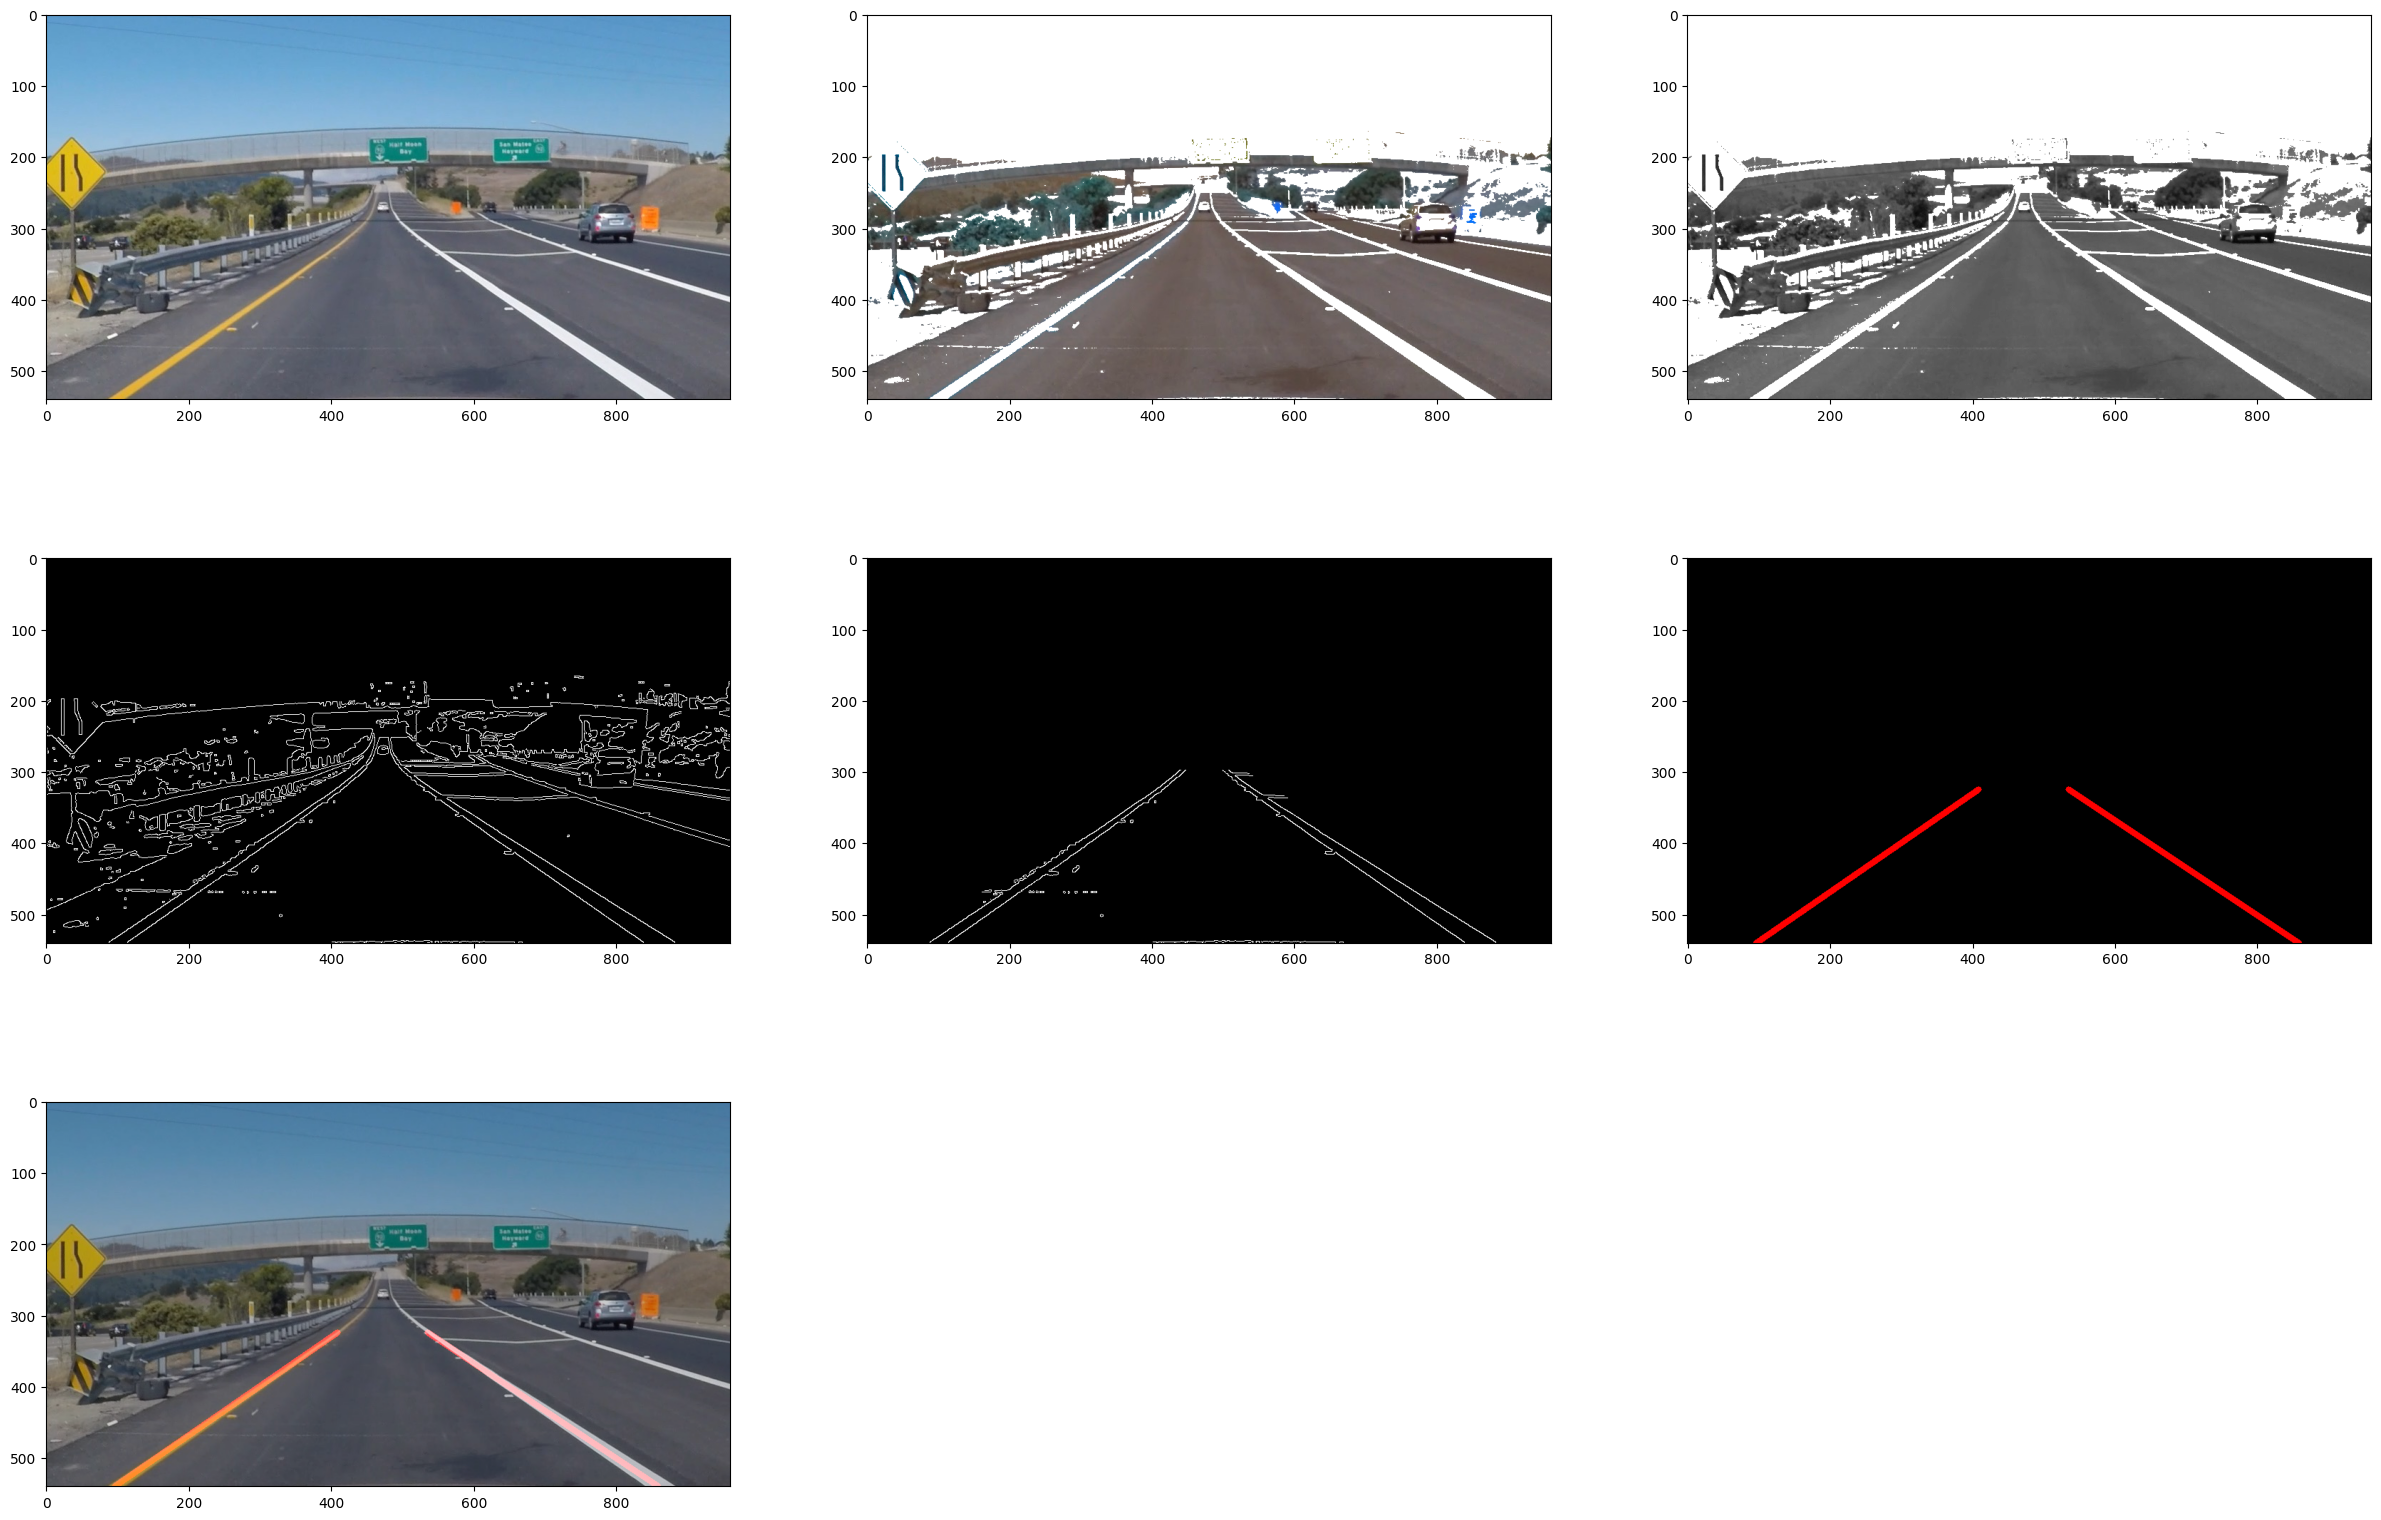

In [ ]:
canny_num = 100

img1 = color_change(image1)
gray_image1 = grayscale(img1)
gaus_blur1 = gaussian_blur(gray_image1, 3)
edges1 = canny(gaus_blur1, 50 , 250)
imshape = image1.shape
# print(imshape)
vertices1 = np.array([[(imshape[1]*0.05,imshape[0]),(imshape[1]*0.45, imshape[0]*0.55), (imshape[1]*0.55, imshape[0]*0.55), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
masked1 = region_of_interest(edges1, vertices1)

rho = 1            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 3  #minimum number of pixels making up a line
max_line_gap = 200  #maximum gap in pixels between connectable line segments
line_image1 = hough_lines(masked1, rho, theta, threshold, min_line_len, max_line_gap)
result1 = weighted_img(line_image1, image1)


fig = plt.figure(figsize=(30,20))

plt.subplot(331), plt.imshow(image1)
plt.subplot(332), plt.imshow(img1)
plt.subplot(333), plt.imshow(gray_image1 ,cmap='gray')
plt.subplot(334), plt.imshow(edges1 ,cmap='gray')
plt.subplot(335), plt.imshow(masked1 ,cmap='gray')
plt.subplot(336), plt.imshow(line_image1)
plt.subplot(337), plt.imshow(result1)

plt.show()

## Image 2

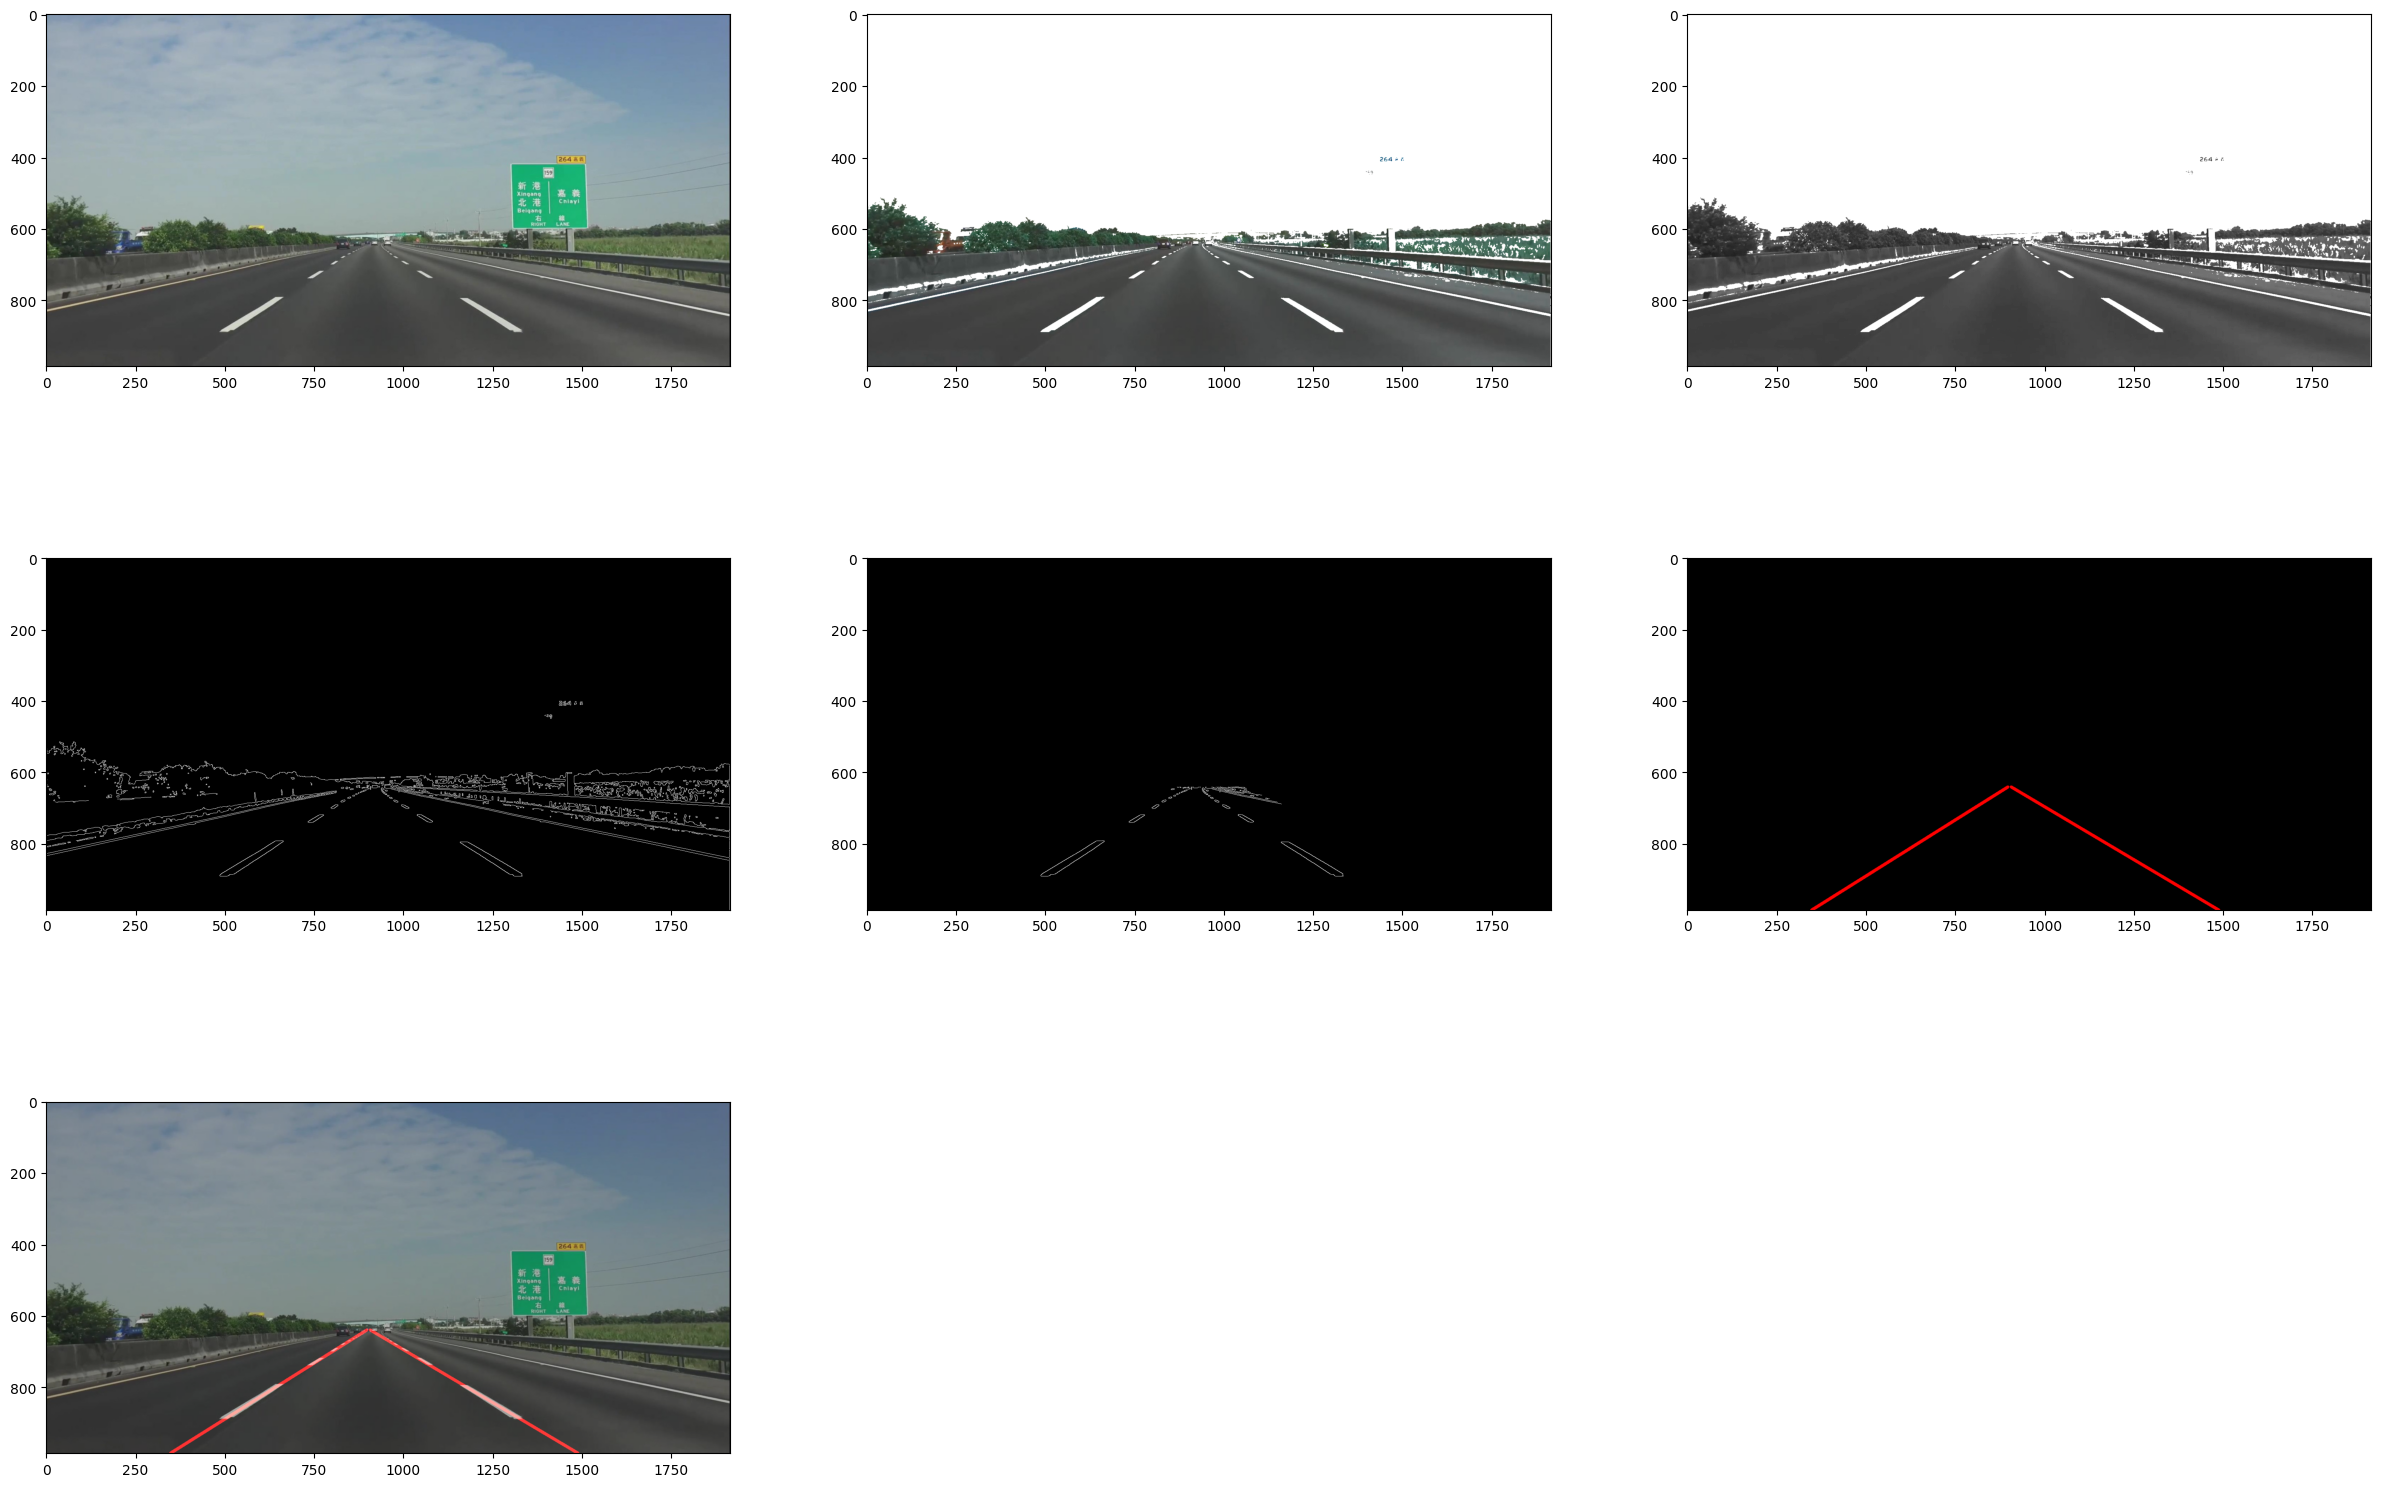

In [ ]:
canny_num = 100

img2 = color_change(image2)
gray_image2 = grayscale(img2)
gaus_blur2 = gaussian_blur(gray_image2, 3)
edges2 = canny(gaus_blur2, 50 , 250)
imshape = image2.shape
# print(imshape)
vertices2 = np.array([[(imshape[1]*0.05,imshape[0]),(imshape[1]*0.45, imshape[0]*0.65), (imshape[1]*0.55, imshape[0]*0.65), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
masked2 = region_of_interest(edges2, vertices2)

rho = 1            #distance resolution in pixels of the Hough grid
theta = np.pi/180  #angular resolution in radians of the Hough grid
threshold = 20     #minimum number of votes (intersections in Hough grid cell)
min_line_len = 3  #minimum number of pixels making up a line
max_line_gap = 200  #maximum gap in pixels between connectable line segments
line_image2 = hough_lines(masked2, rho, theta, threshold, min_line_len, max_line_gap)
result2 = weighted_img(line_image2, image2)


fig = plt.figure(figsize=(30,20))

plt.subplot(331), plt.imshow(image2)
plt.subplot(332), plt.imshow(img2)
plt.subplot(333), plt.imshow(gray_image2 ,cmap='gray')
plt.subplot(334), plt.imshow(edges2 ,cmap='gray')
plt.subplot(335), plt.imshow(masked2 ,cmap='gray')
plt.subplot(336), plt.imshow(line_image2)
plt.subplot(337), plt.imshow(result2)

plt.show()

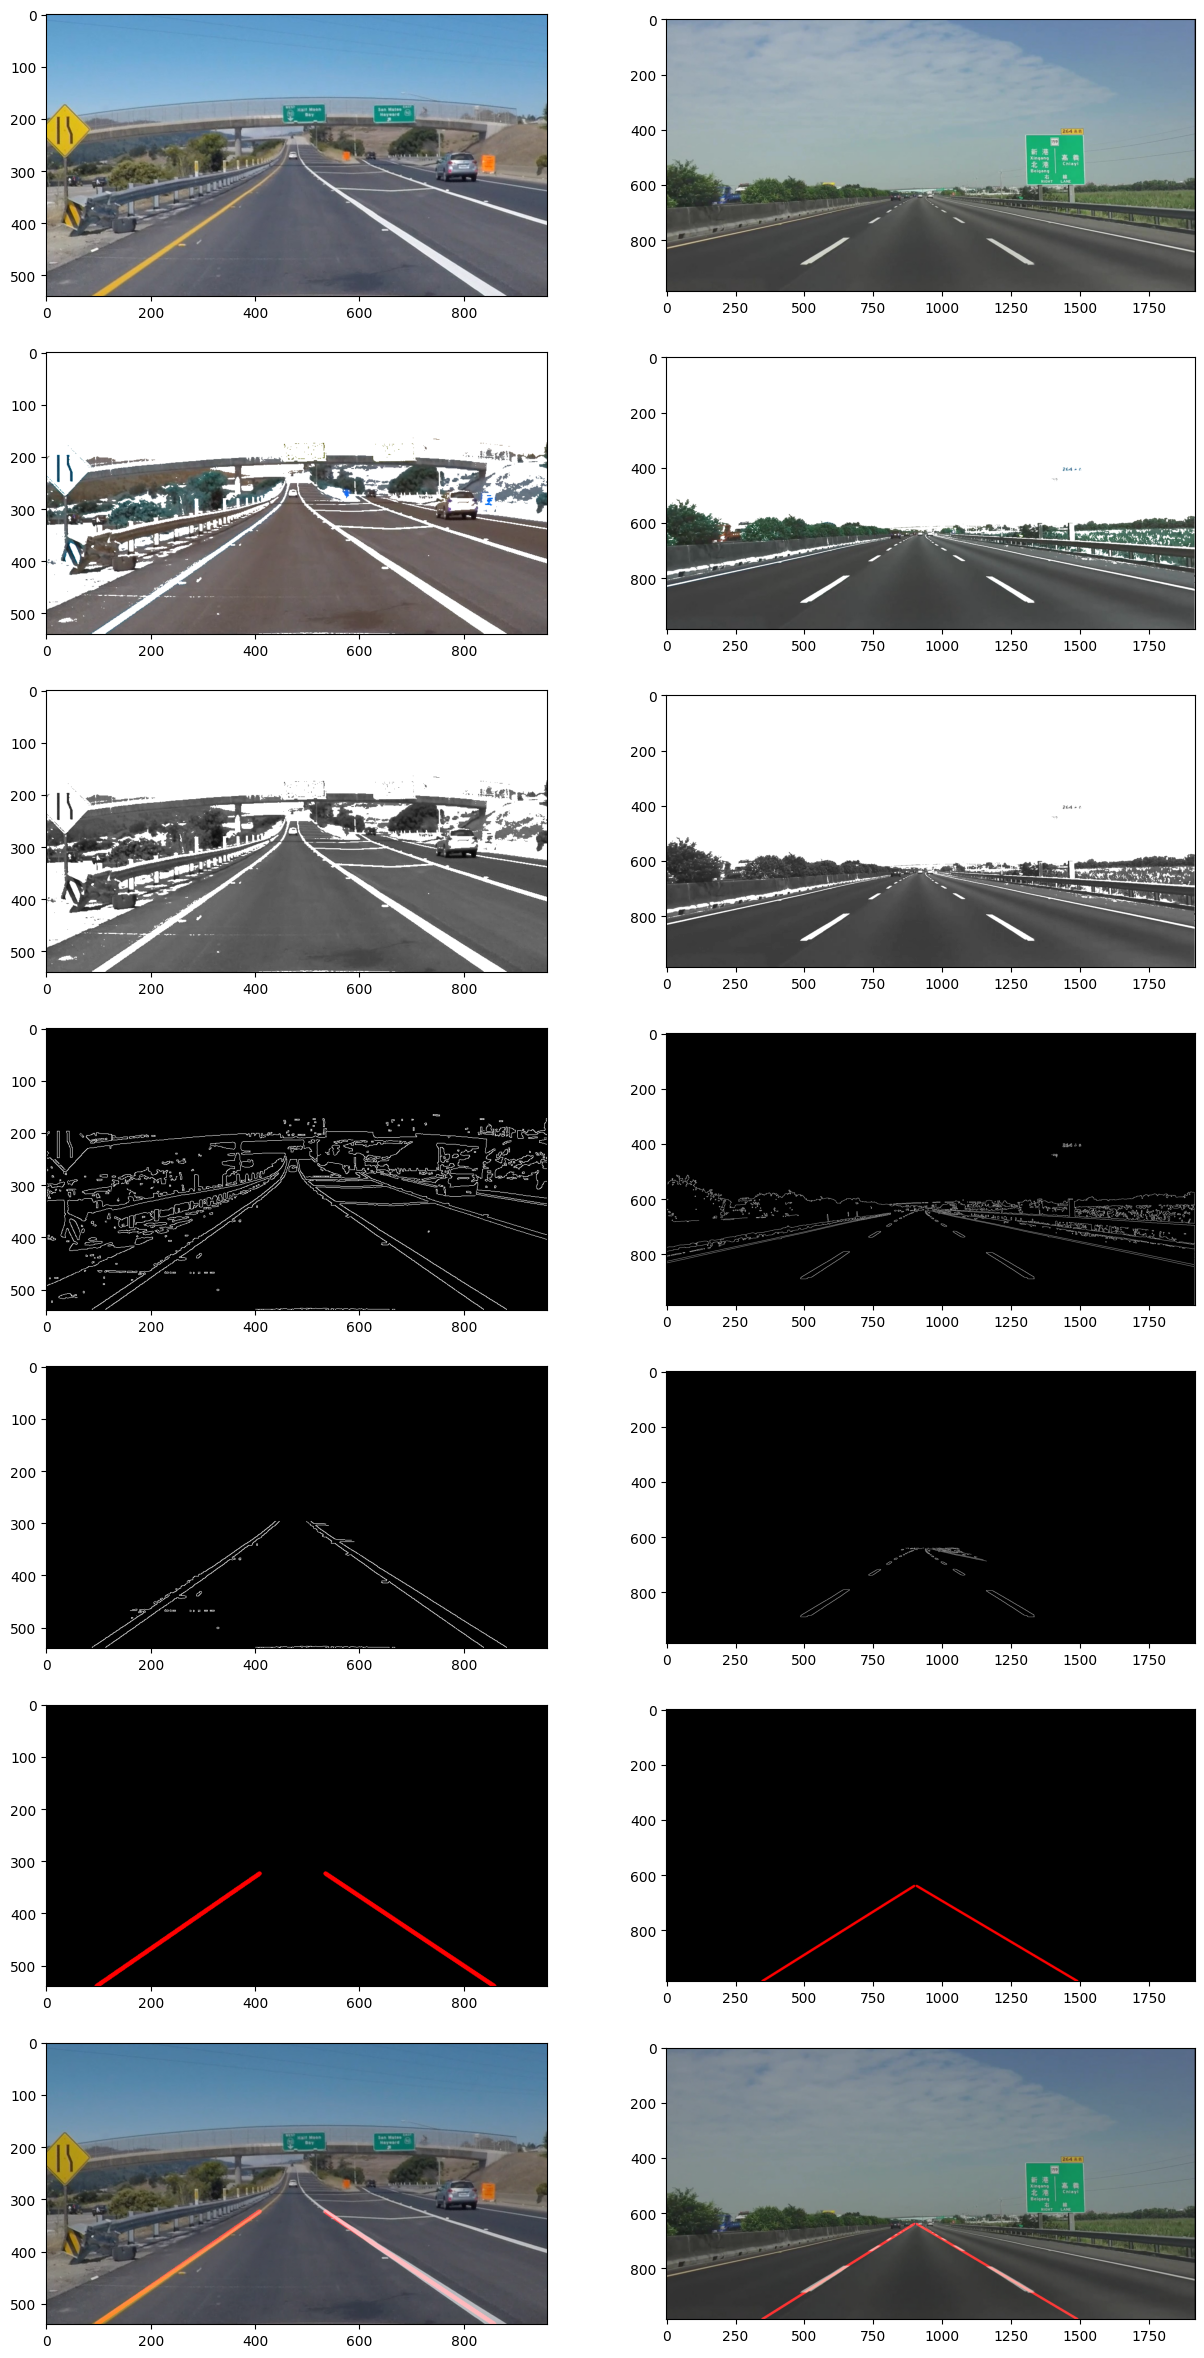

In [ ]:
fig = plt.figure(figsize=(15,30))

plt.subplot(7,2,1), plt.imshow(image1)
plt.subplot(7,2,3), plt.imshow(img1)
plt.subplot(7,2,5), plt.imshow(gray_image1 ,cmap='gray')
plt.subplot(7,2,7), plt.imshow(edges1 ,cmap='gray')
plt.subplot(7,2,9), plt.imshow(masked1 ,cmap='gray')
plt.subplot(7,2,11), plt.imshow(line_image1)
plt.subplot(7,2,13), plt.imshow(result1)

plt.subplot(7,2,2), plt.imshow(image2)
plt.subplot(7,2,4), plt.imshow(img2)
plt.subplot(7,2,6), plt.imshow(gray_image2 ,cmap='gray')
plt.subplot(7,2,8), plt.imshow(edges2 ,cmap='gray')
plt.subplot(7,2,10), plt.imshow(masked2 ,cmap='gray')
plt.subplot(7,2,12), plt.imshow(line_image2)
plt.subplot(7,2,14), plt.imshow(result2)

plt.show()


# Movie Process

In [ ]:

clip1 = VideoFileClip('/content/drive/MyDrive/碩一下/自動駕駛/project1/solidWhiteRight.mp4')
onlineClip_01 = clip1.fl_image(process_image)
onlineClip_01.write_videofile("solidWhiteRight2.mp4",audio = False)



clip2 = VideoFileClip('/content/drive/MyDrive/碩一下/自動駕駛/project1/solidYellowLeft.mp4')
onlineClip_02 = clip2.fl_image(process_image)
onlineClip_02.write_videofile("solidYellowLeft3.mp4",audio = False)


'''
clip3 = VideoFileClip('/content/drive/MyDrive/碩一下/自動駕駛/project1/challenge.mp4')
onlineClip_03 = clip3.fl_image(process_image)
onlineClip_03.write_videofile("challenge3.mp4",audio = False)
'''


cv2.waitKey(0)